In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import re
from tqdm.notebook import tqdm
import requests
import datetime
import time
from collections import Counter
from random import uniform, randint
import warnings

warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from natasha import (Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger,
                     NewsNERTagger, Doc)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (train_test_split, HalvingRandomSearchCV,
                                     GridSearchCV)
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             f1_score, roc_auc_score, classification_report,
                             make_scorer, accuracy_score)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
import optuna

from gensim.models.fasttext import load_facebook_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, ReLU, BatchNormalization, GRU
from keras.models import Sequential
import tensorflow as tf
import tensorflow_addons as tfa
import keras

import gc
import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()
device = torch.device('cuda')

# Experiments

**Замечание**: эксперименты проводятся только на датасете с компаниями

In [9]:
def data_import_from_db(table_name, conn_string):
    db = create_engine(conn_string) 
    conn = db.connect() 
    conn.autocommit = True
    df = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)
    conn.close()
    return df

In [10]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'

conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

In [11]:
df_comp = data_import_from_db('companies_trade', conn_string)

## Predprocessing
- make every word lowercase
- clear the garbage
- delete the stop-words
- lemmatization

In [12]:
additional_stopwords = [
    'которых', 'которые', 'твой', 'которой', 'которого', 'сих', 'ком', 'свой',
    'твоя', 'этими', 'нами', 'всему', 'будь', 'саму', 'никто', 'это',
    'ваше', 'сами', 'наш', 'затем', 'самих', 'наши', 'ту', 'каждое', 'мочь',
    'весь', 'этим', 'наша', 'своих', 'оба', 'который', 'зато', 'те', 'этих',
    'вся', 'ваш', 'такая', 'теми', 'ею', 'которая', 'нередко', 'каждая',
    'также', 'чему', 'собой', 'самими', 'нем', 'вами', 'ими', 'откуда',
    'такие', 'тому', 'та', 'сама', 'нему', 'алло', 'оно', 'этому',
    'кому', 'тобой', 'таки', 'твоё', 'каждые', 'твои', 'нею', 'самим', 'ваши',
    'ваша', 'кем', 'мои', 'однако', 'сразу', 'свое', 'ними', 'всё', 'неё',
    'тех', 'хотя', 'всем', 'тобою', 'тебе', 'одной', 'другие', 'само', 'эта',
    'самой', 'моё', 'своей', 'такое', 'всею', 'будут', 'своего', 'кого',
    'свои', 'мог', 'нам', 'особенно', 'её', 'самому', 'наше', 'кроме',
    'вообще', 'вон', 'мною'
]

stop_words = stopwords.words('russian') + additional_stopwords

In [13]:
# Natasha <3
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [2]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)


def del_stopwords(text):
    clean_tokens = tuple(
        map(lambda x: x if x not in stop_words else '', word_tokenize(text)))
    res_text = ' '.join(clean_tokens)
    return res_text


def lemmatize(text):
    text = Doc(text)
    text.segment(segmenter)
    text.tag_morph(morph_tagger)
    for token in text.tokens:
        token.lemmatize(morph_vocab)
    text.tag_ner(ner_tagger)
    for span in text.spans:
        span.normalize(morph_vocab)
    return ' '.join([token.lemma for token in text.tokens])

In [15]:
txt_lst = []
txts = df_comp.body.copy()

for text in tqdm(txts):
    text = prepare_text(text)
    text = del_stopwords(text)
    text = lemmatize(text)
    txt_lst.append(text)

  0%|          | 0/7267 [00:00<?, ?it/s]

In [16]:
# Save locally file with preprocessed texts (for experiments convenience)
df_comp_safe = pd.concat(
    [df_comp, pd.DataFrame(txt_lst, columns=['text_clear'])],
    axis=1
)

df_comp_safe.to_csv('texts_comp.csv', index=False)

In [3]:
df_comp = pd.read_csv('texts_comp.csv')

for i, text in enumerate(df_comp.text_clear):
    df_comp.loc[i, 'text_clear'] = prepare_text(text).strip()

## Feature generation with TfidfVectorizer and train with XGBClassifier

In [157]:
def plot_cm(y, pred):
    fig, ax = plt.subplots(figsize=(8, 5))
    cm = confusion_matrix(y, pred)
    cmp = ConfusionMatrixDisplay(
        cm, display_labels=[0, 1, 2])
    cmp.plot(ax=ax)
    plt.show()

Определяем, какие классы у нас есть:

In [4]:
p = 0.05

q_l = df_comp.price_diff_percent.quantile(p)
q_u = df_comp.price_diff_percent.quantile(1-p)

df_comp['price_diff_cat'] = 1
df_comp.loc[df_comp['price_diff_percent'] <= q_l, 'price_diff_cat'] = 0
df_comp.loc[df_comp['price_diff_percent'] >= q_u, 'price_diff_cat'] = 2

df_comp[['price_diff_cat']].groupby('price_diff_cat').value_counts()

price_diff_cat
0     364
1    6539
2     364
Name: count, dtype: int64

In [23]:
X, y = np.array(df_comp['text_clear']), np.array(df_comp['price_diff_cat'].values)

# Feature extraction
vectorizer = TfidfVectorizer(min_df=30)
vect_x = vectorizer.fit_transform(X)

In [24]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(vect_x,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=y)

# # Undersampling for better prediction
# nm = NearMiss()
# X_res, Y_res = nm.fit_resample(X_train, y_train)

# # Oversamloing for better prediction
# ros = RandomOverSampler(random_state=42)
# X_res, Y_res = ros.fit_resample(X_train, y_train)

X_res, Y_res = X_train, y_train

In [46]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_res,
                                                          Y_res,
                                                          test_size=0.25,
                                                          stratify=Y_res)

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "multi:softprob",
        'num_class': 3,
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        # L2 regularization weight.
        "reg_lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "reg_alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        'max_delta_step': 1
    }

    if param["booster"] in ["gbtree"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2,
                                                      10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"])

    bst = xgb.train(param, dtrain)

    preds = bst.predict(dvalid)

    cl = []
    for pred in preds:
        cl.append(pred.argmax())

    f1 = f1_score(valid_y, cl, average='macro')

    return f1

In [48]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.39533595568357366
  Params: 
    booster: gbtree
    lambda: 1.0507996308478455e-08
    alpha: 0.0029355676147190257
    subsample: 0.5274983849316145
    colsample_bytree: 0.354304077205616
    max_depth: 9
    min_child_weight: 5
    eta: 0.8775761584245781
    gamma: 1.1312984018031061e-07
    grow_policy: lossguide


Обучение лучшей модели + попытка улучшить качество засчет подбора порога:

In [49]:
xgbc = xgb.XGBClassifier(study.best_params)
xgbc.fit(X_res, Y_res)

test_probas = xgbc.predict_proba(X_test)

best_thr = 0
best_score = 0

for i in range(1, 100):
    thr = 0.01 * i
    
    pred_test = [
        row.argmax() if row.argmax() == 1 and row.max() >= thr
        else row[0:3:2].argmax()
        for row in test_probas
    ]
    
    score = f1_score(y_test, pred_test, average='macro')
    
    if best_score < score:
        best_score = score
        best_thr = thr
        
print(f'Best thr: {best_thr}')
print(f'Best score: {best_score}')

Best thr: 0.79
Best score: 0.3871964244635053


              precision    recall  f1-score   support

           0       0.25      0.20      0.22        91
           1       0.91      0.97      0.94      1635
           2       0.00      0.00      0.00        91

    accuracy                           0.88      1817
   macro avg       0.39      0.39      0.39      1817
weighted avg       0.83      0.88      0.86      1817



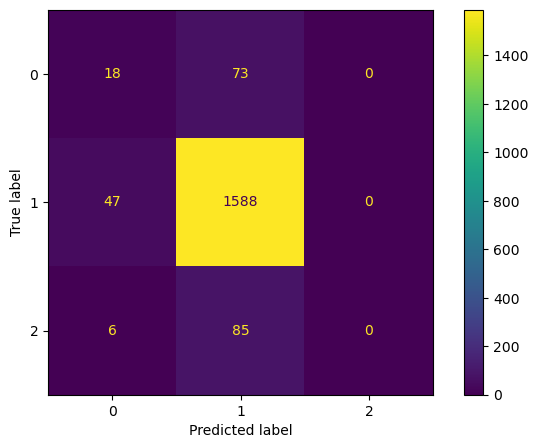

In [50]:
pred_test = [
        row.argmax() if row.argmax() == 1 and row.max() >= best_thr
        else row[0:3:2].argmax()
        for row in xgbc.predict_proba(X_test)
    ]

print(classification_report(y_test, pred_test))
plot_cm(y_test, pred_test)

**Результаты экспериментов:** (некотрые в коде сейчас отсутствуют)
- Oversampling, Undersamplig - качество не улучшилось
- Подбор гиперпараметров - особо качество не улучшилось
- Добавление весов для каждого из классов таргета - качество не улучшилось

## Embeddings generation with FastText and their averaging and train with XGBClassifier

Попробуем сгенерировать менее тривиальные эмбеддинги

**Почему именно FastText?**
- есть предобученная модель под русский язык
- способна генерировать эмбеддинги для неизвестных слов
- неплохо работает на редких словах

**Замечание:** Стоит обратить внмиание, что мы здесь для каждого текста взяли эмбеддинг как усреднение эмбеддингов всех его токенов, этот метод является сомнительным, так как мы теряем очень много информации, но стоит попробовать 

In [107]:
fasttext_model_ru = load_facebook_model('cc.ru.300.bin.gz')

In [143]:
X, y = np.array(df_comp['text_clear']), np.array(df_comp['price_diff_cat'].values)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=y)

X_res, Y_res = X_train, y_train

In [144]:
def get_text_embeddings(text):

    embeddings = [fasttext_model_ru.wv[word] for word in text]
    return sum(embeddings) / len(embeddings)


X_res_emb = []
X_test_emb = []

for text in tqdm(X_res):
    text_embedding = get_text_embeddings(text.split())
    X_res_emb.append(text_embedding)
    
for text in tqdm(X_test):
    text_embedding = get_text_embeddings(text.split())
    X_test_emb.append(text_embedding)

  0%|          | 0/5450 [00:00<?, ?it/s]

  0%|          | 0/1817 [00:00<?, ?it/s]

In [145]:
X_res = X_res_emb
Y_res = Y_res

In [146]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: 0.4021096383180652
  Params: 
    booster: gbtree
    lambda: 0.015156930613926655
    alpha: 0.030909208018206662
    subsample: 0.6958031677996217
    colsample_bytree: 0.8036663452393854
    max_depth: 5
    min_child_weight: 3
    eta: 0.8466070191860348
    gamma: 0.00043490796154456993
    grow_policy: lossguide


In [149]:
xgbc = xgb.XGBClassifier(study.best_params)
xgbc.fit(X_res, Y_res)

test_probas = xgbc.predict_proba(X_test_emb)

best_thr = 0
best_score = 0

for i in range(1, 100):
    thr = 0.01 * i
    
    pred_test = [
        row.argmax() if row.argmax() == 1 and row.max() >= thr
        else row[0:3:2].argmax()
        for row in test_probas
    ]
    
    score = f1_score(y_test, pred_test, average='macro')
    
    if best_score < score:
        best_score = score
        best_thr = thr
        
print(f'Best thr: {best_thr}')
print(f'Best score: {best_score}')

Best thr: 0.96
Best score: 0.3759052661586606


              precision    recall  f1-score   support

           0       0.25      0.05      0.09        91
           1       0.91      0.98      0.94      1635
           2       0.32      0.08      0.12        91

    accuracy                           0.89      1817
   macro avg       0.49      0.37      0.39      1817
weighted avg       0.84      0.89      0.86      1817



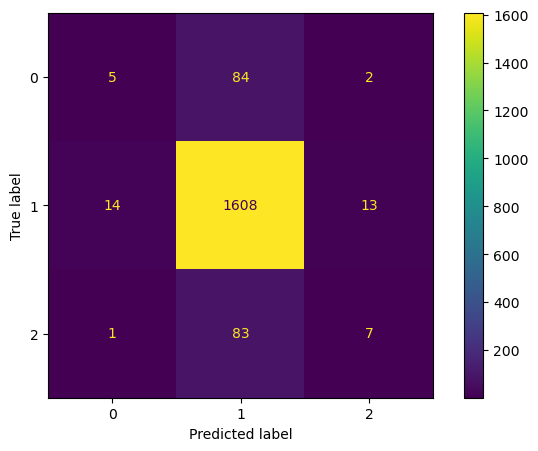

In [160]:
pred_test = [row.argmax() for row in xgbc.predict_proba(X_test_emb)]

print(classification_report(y_test, pred_test))
plot_cm(y_test, pred_test)

**Результаты экспериментов:**
- Подобный способ получения эмбеддингов текстов не помог

## LSTM

In [6]:
def plot_cm(y, pred):
    fig, ax = plt.subplots(figsize=(8, 5))
    cm = confusion_matrix([row.argmax() for row in y], pred)
    cmp = ConfusionMatrixDisplay(
        cm, display_labels=[0, 1, 2])
    cmp.plot(ax=ax)
    plt.show()

In [163]:
texts = df_comp['text_clear']
labels = df_comp['price_diff_cat']

X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=labels)

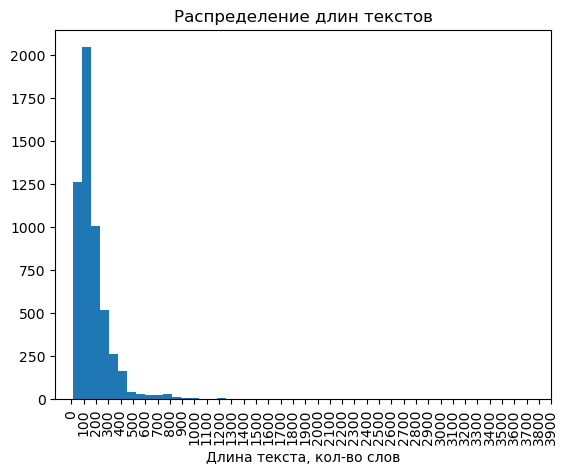

In [164]:
pd.Series([len(str(i).split()) for i in X_train]).hist(bins=40)

plt.xticks(np.arange(0, 4000, 100), rotation='vertical')
plt.title('Распределение длин текстов')
plt.xlabel('Длина текста, кол-во слов')
plt.grid()
plt.show()

In [177]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 500 # dimension of word embeddings
lstm_units = 32 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

In [178]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [179]:
X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [198]:
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(clipvalue=0.7),
              metrics=[tfa.metrics.F1Score(num_classes=num_classes)])

scheduler = keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-5, decay_rate=0.85, decay_steps=100)
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 500)          5000000   
                                                                 
 lstm (LSTM)                 (None, 32)                68224     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 5068323 (19.33 MB)
Trainable params: 5068323 (19.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [199]:
weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights = {i: weight for i, weight in enumerate(weights)}

print(weights)

{0: 6.654761904761905, 1: 0.3704440026507621, 2: 6.654761904761905}


In [200]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=10,
          callbacks=[scheduler],
          class_weight=weights,
          validation_data=(X_test, y_test))

Epoch 1/10
171/171 [==============================] - 152s 886ms/step - loss: 1.0981 - f1_score: 0.2938 - val_loss: 1.0864 - val_f1_score: 0.3178 - lr: 2.5000e-05
Epoch 2/10
171/171 [==============================] - 146s 854ms/step - loss: 1.0909 - f1_score: 0.3677 - val_loss: 1.0801 - val_f1_score: 0.3344 - lr: 2.4911e-05
Epoch 3/10
171/171 [==============================] - 132s 773ms/step - loss: 1.0831 - f1_score: 0.4410 - val_loss: 1.0716 - val_f1_score: 0.3548 - lr: 2.4822e-05
Epoch 4/10
171/171 [==============================] - 139s 813ms/step - loss: 1.0737 - f1_score: 0.4964 - val_loss: 1.0595 - val_f1_score: 0.3667 - lr: 2.4734e-05
Epoch 5/10
171/171 [==============================] - 188s 1s/step - loss: 1.0613 - f1_score: 0.5448 - val_loss: 1.0444 - val_f1_score: 0.3818 - lr: 2.4646e-05
Epoch 6/10
171/171 [==============================] - 177s 1s/step - loss: 1.0424 - f1_score: 0.5757 - val_loss: 1.0144 - val_f1_score: 0.4005 - lr: 2.4558e-05
Epoch 7/10
171/171 [========

In [202]:
# probs_train = model.predict(X_train)
probs_test = model.predict(X_test)

57/57 [==============================] - 18s 315ms/step


In [205]:
best_thr = 0
best_score = 0

for i in range(1, 100):
    thr = 0.01 * i
    
    pred_test = [
        row.argmax() if row.argmax() == 1 and row.max() >= thr
        else row[0:3:2].argmax()
        for row in probs_test
    ]
    
    score = f1_score([row.argmax() for row in y_test], pred_test, average='macro')
    
    if best_score < score:
        best_score = score
        best_thr = thr
        
print(f'Best thr: {best_thr}')
print(f'Best score: {best_score}')

Best thr: 0.01
Best score: 0.3808113465554342



Test:
              precision    recall  f1-score   support

           0       0.17      0.36      0.23        91
           1       0.93      0.87      0.90      1635
           2       0.18      0.16      0.17        91

    accuracy                           0.81      1817
   macro avg       0.42      0.47      0.43      1817
weighted avg       0.85      0.81      0.83      1817



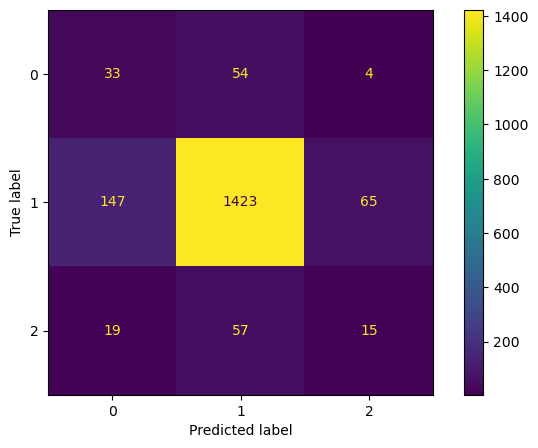

In [206]:
# preds_train = [row.argmax() for row in probs_train]

# print('Train:')
# print(classification_report([row.argmax() for row in y_train], preds_train))
# plot_cm(y_train, preds_train)

preds_test = [row.argmax() for row in probs_test]

print('\nTest:')
print(classification_report([row.argmax() for row in y_test], preds_test))
plot_cm(y_test, preds_test)

**Результаты экспериментов:** (все дальнейшие условия проверялись как вместе, так и обособленно)
- Усложнение модели путем добавления Dense+ReLU+Dropout (одного или нексольких)
- Усложнение модели путем использования Bi-LSTM
- Увеличение/уменьшение batch_size
- Увеличение/уменьшение числа lstm_units
- Увеличение/уменьшение размерности эмбеддингов
- Увеличение/уменьшение максимальной длины текста
- Обучение на большом количестве эпох
- Подбор learning rate

Все это было проделано на пути к получению финальной версии модели.   
Как можно заметить, качество, конечно, лучше, чем в случае TfidfVectorizer+XGBClassifier, но все еще достаточно посредственное

## BERT Fine-tuning

In [9]:
bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

Берем непредобработанные тексты, так как "rubert-base-cased" обучался именно на таких

In [10]:
X, y = df_comp.body, df_comp.price_diff_cat

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=y)

In [11]:
size = 500

tokens_train = tokenizer.batch_encode_plus(
    X_train.values,
    max_length = size,
    padding = 'max_length',
    truncation = True
)

tokens_test = tokenizer.batch_encode_plus(
    X_test.values,
    max_length = size,
    padding = 'max_length',
    truncation = True
)

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.values)

In [13]:
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,
                              sampler=train_sampler,
                              batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data,
                            sampler=test_sampler,
                            batch_size=batch_size)

In [14]:
for param in bert.parameters():
    param.requires_grad = False


class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 3)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [20]:
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

print(class_weights)

weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.to(device)

[6.65445665 0.37044589 6.65445665]


In [21]:
model = BERT_Arch(bert)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)

nll_loss = nn.NLLLoss(weight=weights)
epochs = 10

In [22]:
def train():
    model.train()
    total_loss, f1_macro = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(train_dataloader),
                            total=len(train_dataloader)):
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = nll_loss(preds, labels)
        total_loss += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        preds = preds.detach().cpu().numpy()
        total_preds.extend(preds)

    avg_loss = total_loss / len(train_dataloader)
    
    pred_train = [row.argmax() for row in np.exp(np.array(total_preds))]
    f1_macro = f1_score(train_y, pred_train, average='macro')

    return avg_loss, f1_macro


def evaluate():
    model.eval()
    total_loss, f1_macro = 0, 0
    total_preds = []

    for step, batch in tqdm(enumerate(test_dataloader),
                            total=len(test_dataloader)):
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = nll_loss(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.extend(preds)

    avg_loss = total_loss / len(test_dataloader)
    
    pred_test = [row.argmax() for row in np.exp(np.array(total_preds))]
    f1_macro = f1_score(test_y, pred_test, average='macro')

    return avg_loss, f1_macro

In [23]:
from IPython.display import clear_output

def plot_losses(train_losses, test_metrics):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(test_metrics) + 1), test_metrics, label='test', color='springgreen', linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
def plot_metric(train_metrics, test_metrics):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_metrics) + 1), train_metrics, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(test_metrics) + 1), test_metrics, label='test', color='springgreen', linewidth=2)
    plt.ylabel('f1_macro')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

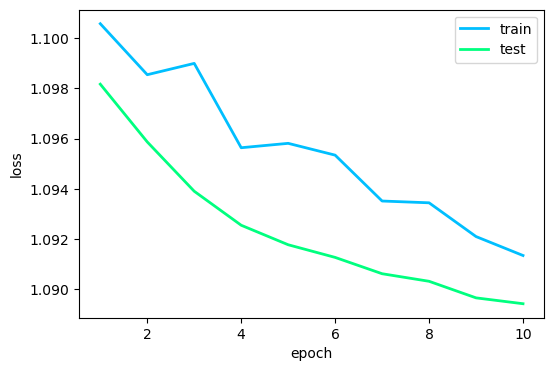

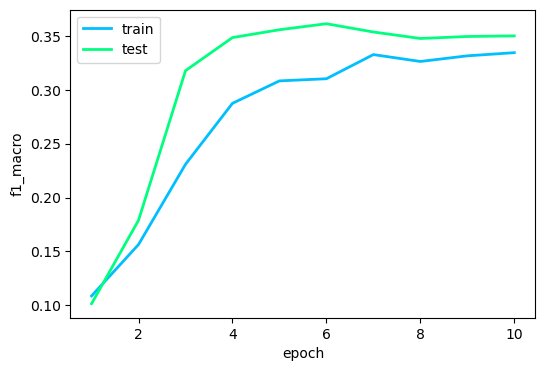

In [24]:
best_test_loss = float('inf')

train_losses = []
test_losses = []

train_metrics = []
test_metrics = []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss, train_metric = train()
    test_loss, test_metric = evaluate()

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    train_metrics.append(train_metric)

    test_losses.append(test_loss)
    test_metrics.append(test_metric)

    print(f'\nTrain loss: {train_loss:.3f}')
    print(f'Train f1: {train_metric:.3f}')
    print(f'Test loss: {test_loss:.3f}')
    print(f'Test f1: {test_metric:.3f}')

plot_losses(train_losses, test_losses)
plot_metric(train_metrics, test_metrics)

torch.cuda.empty_cache()

**Результаты экспериментов:** (все дальнейшие условия проверялись как вместе, так и обособленно)
- Усложнение модели путем добавления Dense+ReLU+Dropout (одного или нексольких)
- Увеличение/уменьшение batch_size
- Увеличение/уменьшение максимальной длины текста
- Обучение на большом количестве эпох
- Подбор learning rate

Все это было проделано на пути к получению финальной версии модели.   
Как можно заметить, мы даже не смогли получить качество лучше чем на TfidfVectorizer+XGBClassifier

# Conclusions

**Модель:** Лучшей моделью оказалась LSTM 

**Общие выводы:**   
Как можно понять, хорошую модель обучить у нас не получилось какую бы конфигурацию мы не подбирали (но, по крайней мере, лучшая модель имеет качество лучше чем просто случайное предсказание)

У нас есть несколько гипотез, почему так произошло:
1. Слишком мало данных
2. Мы пытаемся смоделировать то, что не поддается моделированию

Так как 2-ую проблему мы решить не можем, остается только собрать больше данных и построить модель на них. Это и будет нашим следующим 'чекпоинтом'

Если же большее количество данных не поможет улучшить качество модели, то мы откажемся от нынешней задачи и попробуем решить другую поддающуюся решению схожую задачу на этих данных

In [ ]:
texts = df_comp['text_clear']
labels = df_comp['<>']

X_train, X_test, y_train, y_test = train_test_split(texts,
                                                    labels,
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=labels)

In [ ]:
max_words = 10000 # max number of words to use in the vocabulary
max_len = 500 # max length of each text (in terms of number of words)
embedding_dim = 500 # dimension of word embeddings
lstm_units = 32 # number of units in the LSTM layer
num_classes = len(set(labels)) # number of classes

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(sequences_train, maxlen=max_len)
X_test = pad_sequences(sequences_test, maxlen=max_len)

y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [ ]:
keras.backend.clear_session()

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(LSTM(lstm_units))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(clipvalue=0.7),
              metrics=[tfa.metrics.F1Score(num_classes=num_classes)])

scheduler = keras.callbacks.LearningRateScheduler(
    tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-5, decay_rate=0.85, decay_steps=100)
)

model.summary()

In [ ]:
weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)

weights = {i: weight for i, weight in enumerate(weights)}

print(weights)

In [ ]:
model.fit(X_train,
          y_train,
          batch_size=32,
          epochs=10,
          callbacks=[scheduler],
          class_weight=weights,
          validation_data=(X_test, y_test))

In [ ]:
model.save('artifacts/glob/glob_moex_model.keras')

In [ ]:
keras.models.load_model('artifacts/glob/glob_moex_model.keras')